In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import abstract_network
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('new_files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (256, 256, 3)
files_list = read_pictures('resized_train/')

In [4]:
X_train, X_test = train_test_split(files_list, test_size=0.1)

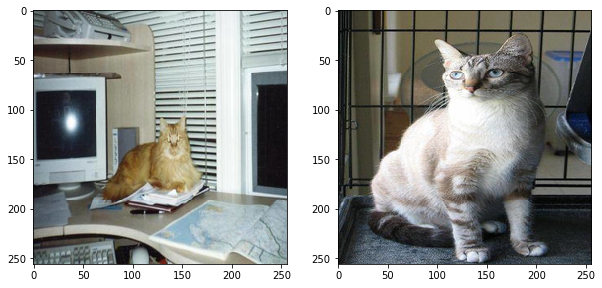

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(plt.imread(X_train[1]));
plt.subplot(122)
plt.imshow(plt.imread(X_train[0]));
plt.show()

In [6]:
class cnn_network(abstract_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
                layer = tf.layers.conv2d(inp, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
        
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
                layer = tf.layers.conv2d(layer, 48, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 48, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
#                 layer = tf.layers.conv2d(layer, 16, , activation=tf.nn.relu)
#                 layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 256, activation=tf.nn.relu)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
#                 layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 3, activation=tf.nn.softmax)

        return layer

In [ ]:
tf.reset_default_graph()
network = cnn_network(input_shape)
network.set_training_data(X_train, X_test)
network.training(batch_size=128, epochs=15, iter_before_validation=1)

32% of training is class 0
32% of training is class 1
34% of training is class 2
33% of test is class 0
32% of test is class 1
34% of test is class 2


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [01:22<00:00,  3.26it/s]


Test accuracy: 77% 	Training loss: 0.869333446690584 	 Training accuracy: 65%


 12%|█████████▎                                                                       | 31/269 [00:10<01:17,  3.08it/s]

In [9]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [10]:
network.freeze_model('saved_model/classifier_with_humans.pb')

INFO:tensorflow:Froze 24 variables.
Converted 24 variables to const ops.
